In [1]:
from typing import List, Dict, Set, Tuple, Optional
import numpy as np
import cv2
import random
from scipy.spatial import distance
import matplotlib.pyplot as plt
from tqdm import tqdm
from two_opt import TwoOpt
from two_point_five_opt import TwoPointFiveOpt
from three_opt import ThreeOpt
from python_tsp.exact import solve_tsp_dynamic_programming
from tsp_solver.greedy import solve_tsp

import time
import copy
import elkai


In [4]:
class LKH(TwoOpt):
    """
    Implementation of the Discrete Grey Wolf Optimizer (DGWO) as described in
    https://doi.org/10.1016/j.asoc.2021.107298
    """

    def __init__(self,
        image: np.ndarray,
        patch_size: Tuple[int,int],
        verbose: Optional[bool]):
            
        super().__init__(image,patch_size,verbose)
        self.history = {i:[] for i in range(len(self.all_graphs))}

    def initialize(self,g: Dict[int, Set[int]]) -> List[List[int]]:
        """
        Initialize the initial population of grey wolves

        Arguments:
        n: number of grey wolves

        Return
        initial_population: the initial population of grey wolves
        """
        nodes = list(g.keys())
        initial_population = random.sample(nodes,len(g))
        return initial_population
    
    def _optimize_one(self,i_g,g):
        """
        Optimize according to the discrete grey wolf optimizer
        """
        nodes = sorted(list(g.keys()))
        weights = self.weight_matrix[nodes][:,nodes]
        weights = elkai.DistanceMatrix(weights)
        order = weights.solve_tsp()
        best_path = list(np.asarray(nodes)[order[:-1]])
        return self.build_path(best_path,self.adj_list,self.local_to_coords)

    def _optimize(self):
        self.seal_path = []
        self.traverse_path = []
        self.all_path_converted = []        

        for i, g in enumerate(self.all_graphs):
            path = self._optimize_one(i,g)
            path = self.build_path(path,self.adj_list,self.local_to_coords)
            self.seal_path.append(path)

        if len(self.seal_path) == 1:
            p = [self.mapping_r[local_node] for local_node in self.seal_path[0]]
            self.all_path_converted.append(p)
            return p        
        else:
            path = []
            path_weights, connect_paths = self.post_path(self.seal_path)
            path_weights[:,0] = 0
            crack_order, _ = solve_tsp_dynamic_programming(path_weights)

            for i in range(len(self.all_graphs)):
                path_converted = []
                path_converted = list(map(lambda x : self.mapping_r[x], self.seal_path[i]))
                self.all_path_converted.append(path_converted)

            path = []
            for i in range(len(self.all_path_converted)-1):
                path.extend(self.all_path_converted[i])
                traverse_path = connect_paths[(i,i+1)]
                path.extend(traverse_path)
                self.traverse_path.append(traverse_path)

            path.extend(self.all_path_converted[-1])

            return path

Preprocessing of graph completed
300
[4, 64, 65, 66, 67, 68, 128, 129, 130, 131, 132, 192, 193, 253, 254, 255, 315, 316, 317, 377, 378, 379, 380, 381, 441, 442, 443, 444, 445, 446, 506, 566, 567, 568, 628, 629, 689, 690, 691, 751, 752, 692, 693, 753, 754, 755, 756, 757, 758, 759, 760, 700, 701, 641, 642, 582, 583, 643, 644, 584, 524, 525, 526, 527, 528, 529, 530, 531, 471, 411, 351, 352, 292, 293, 294, 234, 235, 175, 176, 116, 117, 118, 58, 59, 58, 57, 117, 116, 176, 175, 235, 234, 294, 293, 292, 352, 351, 411, 471, 472, 532, 531, 530, 529, 528, 468, 467, 527, 526, 525, 524, 523, 522, 521, 461, 460, 520, 519, 459, 458, 398, 397, 337, 277, 217, 157, 97, 37, 38, 37, 97, 157, 217, 277, 276, 336, 396, 395, 455, 515, 455, 456, 457, 456, 455, 454, 514, 513, 512, 572, 571, 511, 571, 570, 569, 509, 508, 507, 506, 505, 445, 444, 443, 442, 441, 440, 380, 379, 378, 377, 317, 316, 256, 255, 254, 194, 193, 192, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 182, 181, 180, 240, 241, 242, 182

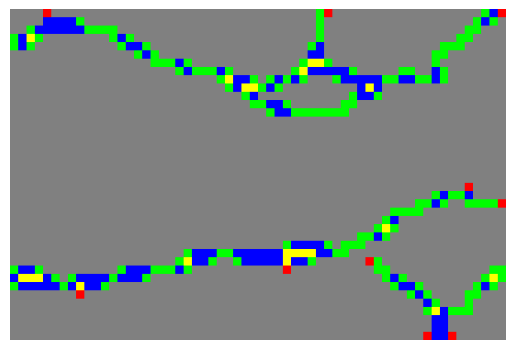

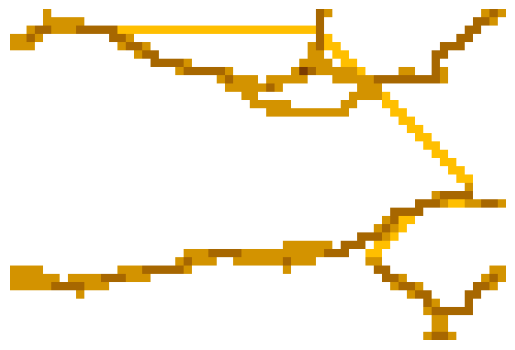

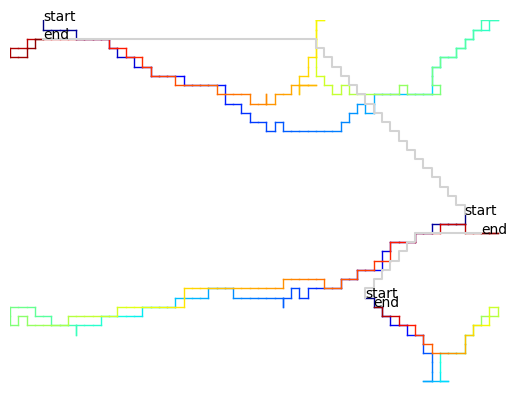

In [5]:
if __name__ == "__main__":
    num_runs = 1
    start_time = time.perf_counter()
    for i in range(num_runs):
        img = cv2.imread("./binary_image/325.png",cv2.IMREAD_UNCHANGED) 
        # img = cv2.imread("./all_cracks/Train/masks/DeepCrack_11123-2.jpg")
        # img = cv2.imread("./val_gt/val_gt/01460.png")
        if len(img.shape) == 3:
            img = np.any(img > 0, axis=-1)

        ps = (8,8)
        x = LKH(img,ps,False)
        print(x.num_vertex)
        path = x._optimize()
        print(path)
        print(x.check_all_path())
        # x.get_statistics("Improved Discrete Grey Wolf",20,x.history)
        x.draw_path()

    end_time = time.perf_counter()
    print(f"Average time = {(end_time - start_time)/num_runs}")
